In [ ]:
!pip install tensorflow

### **Import Dataset**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('https://raw.githubusercontent.com/ShinyQ/Tugas-Pemrograman-1_NLP/main/twitter_training.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/ShinyQ/Tugas-Pemrograman-1_NLP/main/twitter_validation.csv')

# Change Column Name
df_train.columns = ['id', 'name', 'sentiment', 'text']
df_test.columns = ['id', 'name', 'sentiment', 'text']

df_train = df_train[['text', 'sentiment']]
df_test = df_test[['text', 'sentiment']]

# Drop NaN Data
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [ ]:
df_train["sentiment"] = df_train["sentiment"].map({
    "Negative": 0, 
    "Neutral": 1, 
    "Positive": 2,
    "Irrelevant": 3
})

df_test["sentiment"] = df_test["sentiment"].map({
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
    "Irrelevant": 3
})

In [ ]:
df_train.sample(5)

,text,sentiment
16754,KeemStar? Close.,3
61859,Grand Theft Auto was educational after all.,2
29531,@Respawn @PlayApex @lowkeydbjosh How many mo...,0
7907,Bruh .,0
29869,Get on stream @ PlayApex with 30 minutes left ...,1


In [ ]:
df_test.sample(5)

,text,sentiment
468,Driving through New Mexico is like driving thr...,3
976,This is....odd. @Google suggests the most dead...,1
743,"Holy shit, how pissed off do you have to be to...",3
268,woops made a bunch of boomer men mad on facebo...,1
523,One game of fifa tonight and I’m done. Pressin...,0


In [ ]:
# Menghapus Data Null Pada Dataset
df_train['text'].replace('', np.nan, inplace=True)
df_train.dropna(subset=['text'], inplace=True)

df_test['text'].replace('', np.nan, inplace=True)
df_test.dropna(subset=['text'], inplace=True)

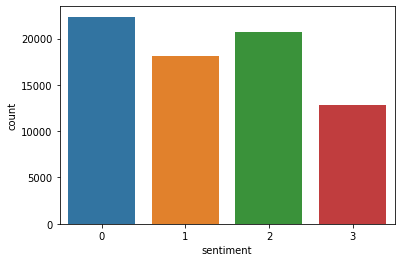

In [ ]:
sns.countplot(data=df_train, x='sentiment')
plt.show()

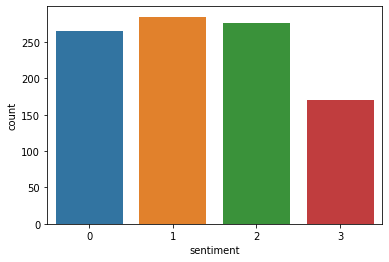

In [ ]:
sns.countplot(data=df_test, x='sentiment')
plt.show()

### **Neural Based Classification (LSTM)**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 128

trunc_type = 'post'
padding_type = 'post'

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_train['text'], 
    df_train['sentiment'],
    test_size=0.2, 
    random_state=42
)

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index

In [ ]:
dict(list(word_index.items())[0:10])

{'a': 5,
 'and': 4,
 'for': 9,
 'i': 2,
 'in': 8,
 'is': 7,
 'of': 6,
 'the': 1,
 'this': 10,
 'to': 3}

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(X_val)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
train_padded[100]

array([1578,   76,    5,  543,    6,  116,  168,  308,    9,  315,    3,
       1024,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 394,564
Trainable params: 394,564
Non-trainable params: 0
_________________________________________________________________


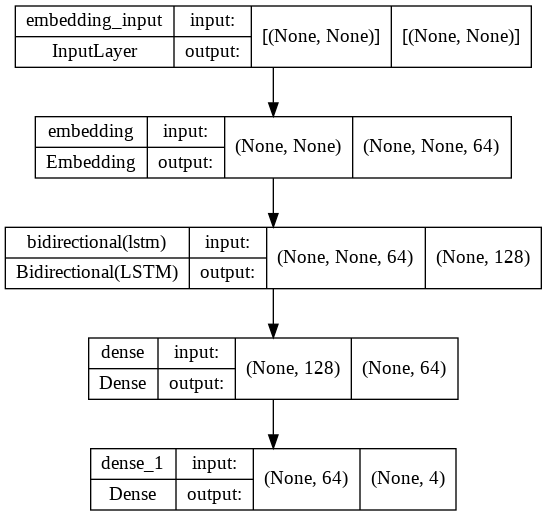

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import timeit
start = timeit.default_timer()

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=2,
    restore_best_weights=True
)

num_epochs = 15

history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128,
    epochs=num_epochs,
    callbacks=[early_stopping],
    validation_data=(validation_padded, y_val), 
)


Epoch 1/15
463/463 [==============================] - 28s 39ms/step - loss: 1.0065 - accuracy: 0.5794 - val_loss: 0.8111 - val_accuracy: 0.6833
Epoch 2/15
463/463 [==============================] - 9s 20ms/step - loss: 0.6830 - accuracy: 0.7376 - val_loss: 0.6860 - val_accuracy: 0.7389
Epoch 3/15
463/463 [==============================] - 8s 18ms/step - loss: 0.5397 - accuracy: 0.7955 - val_loss: 0.6213 - val_accuracy: 0.7671
Epoch 4/15
463/463 [==============================] - 8s 18ms/step - loss: 0.4437 - accuracy: 0.8333 - val_loss: 0.5656 - val_accuracy: 0.7924
Epoch 5/15
463/463 [==============================] - 9s 19ms/step - loss: 0.3763 - accuracy: 0.8590 - val_loss: 0.5635 - val_accuracy: 0.8021
Epoch 6/15
463/463 [==============================] - 9s 19ms/step - loss: 0.3304 - accuracy: 0.8765 - val_loss: 0.5504 - val_accuracy: 0.8113
Epoch 7/15
463/463 [==============================] - 16s 34ms/step - loss: 0.2962 - accuracy: 0.8888 - val_loss: 0.5630 - val_accuracy: 0.81

In [ ]:
stop = timeit.default_timer()
print('Waktu Training: ', (stop - start) / 60, 'Menit')  

Waktu Training:  1.5907114468500008 Menit


### **Evaluation Mode**

In [ ]:
def plot_history(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])

    plt.xlabel("Epochs")
    plt.ylabel(string)

    plt.legend([string, 'val_'+string])
    plt.show()

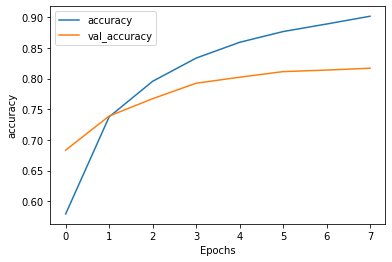

In [ ]:
plot_history(history, "accuracy")

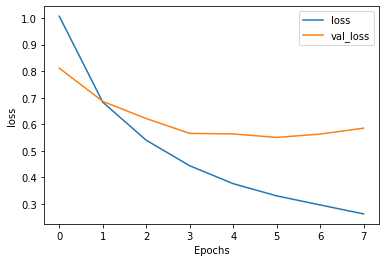

In [ ]:
plot_history(history, "loss")

In [ ]:
test_sequences = tokenizer.texts_to_sequences(df_test['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = np.argmax(model.predict(test_padded), axis=1)

              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93       274
     Neutral       0.92      0.95      0.94       277
    Positive       0.92      0.91      0.92       282
  Irrelevant       0.91      0.94      0.93       166

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999



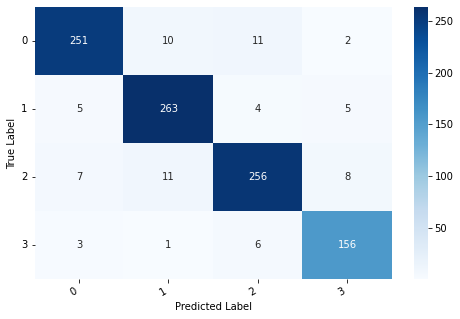

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def show_confusion_matrix(confusion_matrix):
        plt.figure(figsize=(8, 5))
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

print(classification_report(prediction, df_test['sentiment'], target_names=["Negative", "Neutral", "Positive", "Irrelevant"]))

cm = confusion_matrix(prediction, df_test['sentiment'])
show_confusion_matrix(cm)


### **N-Gram Based Classification**

Waktu Training:  0.00038388556666670107 Menit
1-Gram



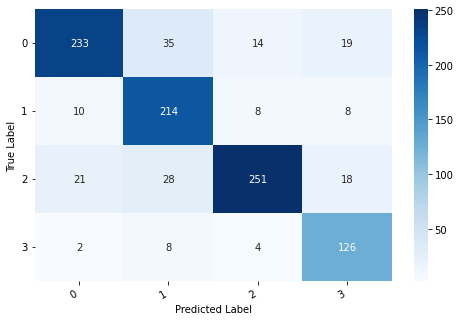


              precision    recall  f1-score   support

    Negative       0.88      0.77      0.82       301
     Neutral       0.75      0.89      0.82       240
    Positive       0.91      0.79      0.84       318
  Irrelevant       0.74      0.90      0.81       140

    accuracy                           0.82       999
   macro avg       0.82      0.84      0.82       999
weighted avg       0.84      0.82      0.83       999


Waktu Training:  0.0010717339999985142 Menit
2-Gram



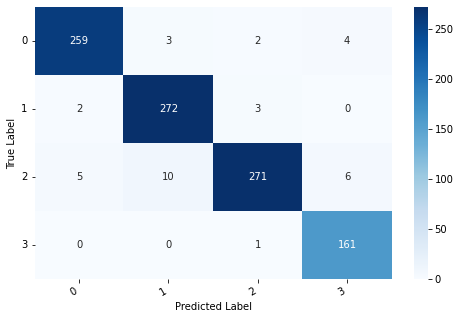


              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97       268
     Neutral       0.95      0.98      0.97       277
    Positive       0.98      0.93      0.95       292
  Irrelevant       0.94      0.99      0.97       162

    accuracy                           0.96       999
   macro avg       0.96      0.97      0.96       999
weighted avg       0.96      0.96      0.96       999


Waktu Training:  0.0023209439666667703 Menit
3-Gram



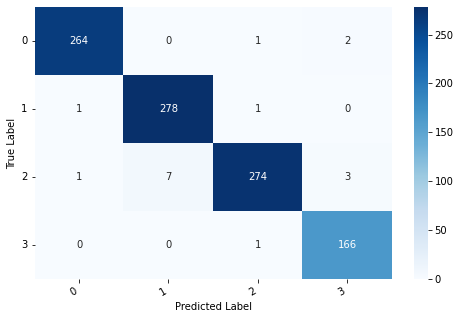


              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99       267
     Neutral       0.98      0.99      0.98       280
    Positive       0.99      0.96      0.98       285
  Irrelevant       0.97      0.99      0.98       167

    accuracy                           0.98       999
   macro avg       0.98      0.98      0.98       999
weighted avg       0.98      0.98      0.98       999


Waktu Training:  0.00922910321666753 Menit
4-Gram



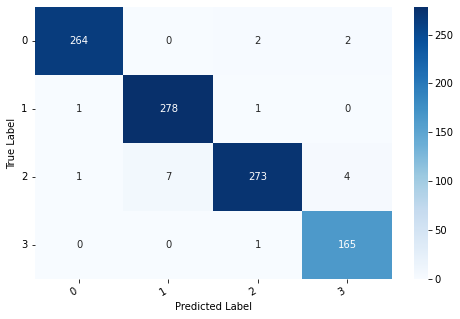


              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99       268
     Neutral       0.98      0.99      0.98       280
    Positive       0.99      0.96      0.97       285
  Irrelevant       0.96      0.99      0.98       166

    accuracy                           0.98       999
   macro avg       0.98      0.98      0.98       999
weighted avg       0.98      0.98      0.98       999




In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# melatih model dengan rentang n-gram yang berbeda
for N in range(1, 5):

    # Mengubah data train menjadi representasi N-Gram sesuai perulangan
    cv = CountVectorizer(analyzer = 'word', ngram_range=(1, N))
    
    X_train_cv = cv.fit_transform(df_train['text'])
    X_test_cv = cv.transform(df_test['text'])
    
    # melatih model dan menghasilkan prediksi
    start = timeit.default_timer()

    clf = MultinomialNB()
    clf.fit(X_train_cv, df_train['sentiment'])

    stop = timeit.default_timer()
    print('Waktu Training: ', (stop - start) / 60, 'Menit')  
    
    y_pred = clf.predict(X_test_cv)

    print(f'{N}-Gram\n')

    cm = confusion_matrix(y_pred, df_test['sentiment'])
    show_confusion_matrix(cm)  
    print('')
    
    print(classification_report(
        y_pred, 
        df_test['sentiment'], 
        target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
    )

    print('')